## Water Injection Dredging 
This notebook is made to simulate the workflow of a Water Injection Dredging which is a method used for maintenance dredging. This method is conducted by Water Injection Dredgers (WID) by injecting water with a jetbar and multiple nozzles to the sediment bed, fluidize the sediments, and leads the sediments to the open sea using currents and waves.

The WID module is generated by defining a "processor_wid" mixin and "produce_amount_activity" activity. These two files can be found in the src folder of OpenCLSim branch "opentnsim-openclsim-demo-notebooks".

The main logic behind the notebook is to dredge sediments without loading them in another destination. The sediment is washed out from the system by the prodcution rate and hydrodynamics are not included in the model.

#### 0. Import libraries

In [1]:
# import datetime, time
import simpy
import shapely.geometry
import pandas as pd
import inspect
import sys 
import os 
import matplotlib.pyplot as plt

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import openclsim.plugins as plugins

#### 1. Define simpy environment and start simulation

In [2]:
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable, 
        core.HasResource,
        core.Processor,
        core.Identifiable,
        core.Log,
    ),
    {},
)

TransportProcessingResource_wid = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable, 
        core.HasResource,
        core.Processor_wid,
        core.Identifiable,
        core.Log,
    ),
    {},
)

#### 3. Define site(s) and vessel(s)

In [4]:
location_dredging_site = shapely.geometry.Point(4.057883, 51.947782)

data_dredging_site = {
    "env": my_env,
    "name": "amazonehaven",
    "geometry": location_dredging_site,    
    "capacity":150000,
    "level":150000,
    "nr_resources": 2,
}
Dredging_site = Site(**data_dredging_site)

# prepare input data for lowsal (dischargin location)
location_dump = shapely.geometry.Point(4.077757, 52.028624)
data_dump = {
    "env": my_env,
    "name": "lowsal",
    "geometry": location_dump,
    "capacity": 6000000,
    "level": 0,
}
dump = Site(**data_dump)




# prepare input data for vessels
data_tshd = {
    "env": my_env,
    "name": "tshd",
    "geometry": location_dump,
    "capacity": 25000,
    "compute_v": lambda x: 10 + 2 * x,
}
tshd = TransportProcessingResource(**data_tshd)

data_wid = {
    "env": my_env,
    "name": "WID vessel",
    "geometry": location_dredging_site,  
    "capacity":1740,
    "compute_v": lambda x: 1
}

wid = TransportProcessingResource_wid(**data_wid)

#### 4. Define water injection dredging activity

In [5]:
registry = {}

In [6]:
subprocesses_tshd = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty tshd",
        registry=registry,
        mover=tshd,
        destination=Dredging_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading tshd",
        registry=registry,
        processor=tshd,
        origin=Dredging_site,
        destination=tshd,
        amount=25000,
        duration=3*3600,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full tshd",
        registry=registry,
        mover=tshd,
        destination=dump,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading tshd",
        registry=registry,
        processor=tshd,
        origin=tshd,
        destination=dump,
        amount=25000,
        duration=0.5*3600,
    ),
]

# Define activities of the dredging vessel
activities_tshd = model.WhileActivity(
    env=my_env,
    name="while sequential dredging tshd",
    registry=registry,
    sub_processes=[
        model.SequentialActivity(
            env=my_env,
            name=f"sequential activity dredging tshd",
            registry=registry,
            sub_processes=subprocesses_tshd,
        )
    ],
    condition_event=[
        {
            "type": "container",
            "concept": Dredging_site,
            "state": "empty",
            "id_": "default_reservations",
        }
    ],
)

In [7]:
sub_processes_wid = [
    model.ProduceAmountActivity(
        env=my_env,
        WIDprocessor=wid,
        destination =wid,
        origin=Dredging_site,
        name='WID activity',
        registry=registry,
        amount=1740,
        duration=0.5*3600,
    ),
]

activities_wid = model.WhileActivity(
    env=my_env,
    name='While activity',
    registry=registry,
    sub_processes=sub_processes_wid,
    condition_event=[
        {"type":"container", "concept":Dredging_site,"state":"empty"}
    ],
)

#### 5. Register the processes and run the simulation

In [8]:
model.register_processes([activities_tshd])
model.register_processes([activities_wid])
my_env.run()

mover tshd destination amazonehaven
updating to destination geometry POINT (4.057883 51.947782)
mover tshd destination lowsal
updating to destination geometry POINT (4.077757 52.028624)
mover tshd destination amazonehaven
updating to destination geometry POINT (4.057883 51.947782)
mover tshd destination lowsal
updating to destination geometry POINT (4.077757 52.028624)
mover tshd destination amazonehaven
updating to destination geometry POINT (4.057883 51.947782)
mover tshd destination lowsal
updating to destination geometry POINT (4.077757 52.028624)
mover tshd destination amazonehaven
updating to destination geometry POINT (4.057883 51.947782)
mover tshd destination lowsal
updating to destination geometry POINT (4.077757 52.028624)


In [9]:
display(plot.get_log_dataframe(tshd, [activities_tshd, *subprocesses_tshd]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing empty tshd,1970-01-01 00:00:00.000000,START,POINT (4.077757 52.028624),0.0
1,sailing empty tshd,1970-01-01 00:15:09.807691,STOP,POINT (4.057883 51.947782),0.0
2,loading tshd,1970-01-01 00:15:09.807691,START,POINT (4.057883 51.947782),0.0
3,loading tshd,1970-01-01 03:15:09.807691,STOP,POINT (4.057883 51.947782),25000.0
4,sailing full tshd,1970-01-01 03:15:09.807691,START,POINT (4.057883 51.947782),25000.0
5,sailing full tshd,1970-01-01 03:27:47.980766,STOP,POINT (4.077757 52.028624),25000.0
6,unloading tshd,1970-01-01 03:27:47.980766,START,POINT (4.077757 52.028624),25000.0
7,unloading tshd,1970-01-01 03:57:47.980766,STOP,POINT (4.077757 52.028624),0.0
8,sailing empty tshd,1970-01-01 03:57:47.980766,START,POINT (4.077757 52.028624),0.0
9,sailing empty tshd,1970-01-01 04:12:57.788457,STOP,POINT (4.057883 51.947782),0.0


In [10]:
df_WID = pd.concat(
    [
        plot.get_log_dataframe(wid, [activities_wid, *sub_processes_wid])
        for act in sub_processes_wid
    ]
).sort_values(by=['Timestamp'])
df_SITE = pd.concat(
    [
        plot.get_log_dataframe(Dredging_site, [activities_wid, *sub_processes_wid])
        for act in sub_processes_wid
    ]
).sort_values(by=['Timestamp'])

#### 6. Obtain activity log

In [11]:
display(plot.get_log_dataframe(wid, [activities_wid, *sub_processes_wid]))

,Activity,Timestamp,ActivityState,geometry,container level
0,WID activity,1970-01-01 00:00:00,START,POINT (4.057883 51.947782),0.0
1,WID activity,1970-01-01 00:30:00,STOP,POINT (4.057883 51.947782),0.0
2,WID activity,1970-01-01 00:30:00,START,POINT (4.057883 51.947782),0.0
3,WID activity,1970-01-01 01:00:00,STOP,POINT (4.057883 51.947782),0.0
4,WID activity,1970-01-01 01:00:00,START,POINT (4.057883 51.947782),0.0
5,WID activity,1970-01-01 01:30:00,STOP,POINT (4.057883 51.947782),0.0
6,WID activity,1970-01-01 01:30:00,START,POINT (4.057883 51.947782),0.0
7,WID activity,1970-01-01 02:00:00,STOP,POINT (4.057883 51.947782),0.0
8,WID activity,1970-01-01 02:00:00,START,POINT (4.057883 51.947782),0.0
9,WID activity,1970-01-01 02:30:00,STOP,POINT (4.057883 51.947782),0.0


In [12]:
display(plot.get_log_dataframe(Dredging_site, [activities_wid, activities_tshd]))

,Activity,Timestamp,ActivityState,container level,geometry
0,WID activity,1970-01-01 00:00:00.000000,START,150000,POINT (4.057883 51.947782)
1,loading tshd,1970-01-01 00:15:09.807691,START,148260,POINT (4.057883 51.947782)
2,WID activity,1970-01-01 00:30:00.000000,STOP,123260,POINT (4.057883 51.947782)
3,WID activity,1970-01-01 00:30:00.000000,START,123260,POINT (4.057883 51.947782)
4,WID activity,1970-01-01 01:00:00.000000,STOP,121520,POINT (4.057883 51.947782)
...,...,...,...,...,...
61,WID activity,1970-01-01 13:30:00.000000,START,3020,POINT (4.057883 51.947782)
62,WID activity,1970-01-01 14:00:00.000000,STOP,1280,POINT (4.057883 51.947782)
63,WID activity,1970-01-01 14:00:00.000000,START,1280,POINT (4.057883 51.947782)
64,WID activity,1970-01-01 14:30:00.000000,STOP,0,POINT (4.057883 51.947782)


#### 7. Results in a Gantt chart

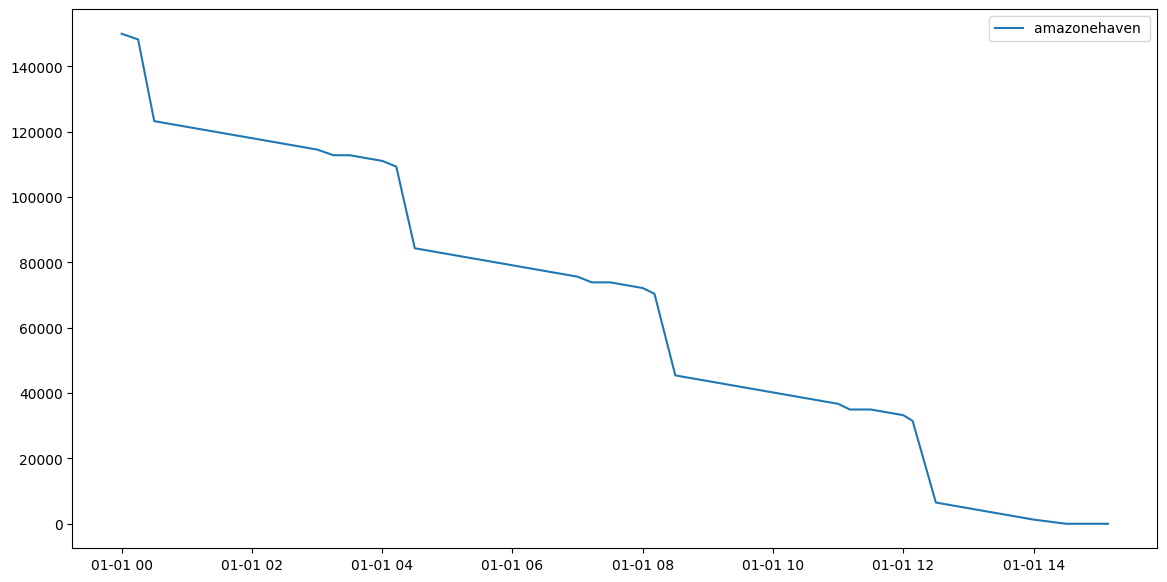

In [13]:
fig = plot.get_step_chart([Dredging_site])